# Analysing job descriptions to extract the most commonly occuring phrases using n-gram frequency analysis

The objective of this project is to scrape some job descriptions for data science roles from a job board and then perform an n-gram frequency analysis to determine the most commonly occurring phrases.

In [ ]:
# !pip install selenium

In [1]:
# import libraries

from selenium import webdriver
import re
import os
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import scipy.stats as stats
import random
import numpy as np
import seaborn as sns

In [7]:
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data collection - web scraping

I used selenium for webscraping as the webpage was not a static one and included JavaScript functions for redirection from the root URL.

In [ ]:
# setting options for chromedriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("User-Agent=Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")


# path to chromedriver.exe

os.environ['PATH'] += r"C:\\Users\\hp\\Downloads\\chromedriver_win32\\chromedriver"

In [ ]:
job_id = []
i = 0
while len(job_id)<300:     # collecting 300 job details
    
    driver = webdriver.Chrome(options=chrome_options)    # webdriver object

    base_url = 'https://uk.indeed.com/jobs?q=data+scientist&l=united+kingdom&start='
    url = base_url+str(i)
    try:
        driver.get(url)

        html_content = driver.page_source

        soup = BeautifulSoup(html_content, 'html.parser')

        driver.quit()

        jobs = soup.find_all('h2', class_ = 'jobTitle css-1h4a4n5 eu4oa1w0')
        
        for job in jobs:
            id = job.find('a').get('id')   # collecting only the job IDs which will be used later
            job_id.append(id)
        
        i+=10
        
    except:
        i+=10
        continue

In [ ]:
# preparing an empty dataframe for storing job data

job_df = pd.DataFrame(columns = ['Id', 'Title', 'Metadata', 'Description'])

In [ ]:
# again using selenium for dynamic webpage

for i in range(len(job_id)):
    driver = webdriver.Chrome(options=chrome_options)
    job_url = "https://uk.indeed.com/jobs?q=data+scientist&l=united+kingdom&vjk="+job_id[i][4:]

    try:
        driver.get(job_url)
        wait = WebDriverWait(driver, 60)   # webdriver waits until the html element loads up
        wait.until(EC.presence_of_element_located((By.ID, "jobDescriptionText")))
        html_content = driver.page_source
        soup = BeautifulSoup(html_content, 'html.parser')
        driver.quit()
        
        # all fields are under try block as sometimes elements do not load even after waiting
        try:
            title = soup.find('div', class_ = "jobsearch-JobInfoHeader-title-container").text
        except:
            title = None
            
        try:
            meta = soup.find('div', class_ = "jobsearch-JobMetadataHeader-item").text
        except:
            meta = None
            
        try:
            desc = soup.find('div', class_ = "jobsearch-jobDescriptionText jobsearch-JobComponent-description").text
        except:
            desc = None
            
        job_df.loc[i] = [job_id[i][4:], title, meta, desc]

    except:
        job_df.loc[i] = [job_id[i][4:], None, None, None]
        continue

In [ ]:
# job_df.to_csv('jobs_raw.csv', index=False)

# Data preprocessing

In [56]:
job_df = pd.read_csv('jobs_raw.csv')

In [57]:
# how the freshly scraped data looks like lol

job_df.head()

,Id,Title,Metadata,Description
0,3179097cc1c691d7,Data Scientist Degree Apprenticeship - job post,"£23,400 - £29,745 a year - Full-time, Apprent...",\nOur people work differently depending on the...
1,1ddfdbc687b1c4f1,Senior Data Scientist - job post,"Full-time, Permanent",\n\n\n\n\n Job Advert\n \n\n Are you pass...
2,ff561f48cb931d5f,Graduate Data Scientist/Physicist - job post,Full-time,\n Overview: \n Weatherford is a leading glob...
3,ec6274ab803db1de,Data Scientist - job post,"£40,000 - £60,000 a year - Full-time, Part-time",Are you looking to take your data career to th...
4,85580358ec19921b,"Junior Data Scientist - FP&D, NHS Exec - job post","£27,461 - £33,428 a year - Permanent","\nAs we expand our Data Science team, we are l..."


In [58]:
# slicing some field values and dropping some columns

for i in range(len(job_df)):
    job_df['Title'].loc[i] = job_df['Title'].loc[i][:-11]
    
job_df.drop(columns=['Id'], inplace=True)
job_df.dropna(subset=['Description'], inplace=True)
job_df.reset_index(drop=True, inplace=True)

In [42]:
# extracts only the numerical bits, i.e. salary range

def clean_meta(data):
    if type(data)==str:
        data = data.replace(',', '')
        data = re.findall(r'\d+', data)
    
    if type(data)==list and len(data)==0:
        data = float('NaN')
        
    return data

In [43]:
# keeps only the main portion of the job title and converts it into lowercase

def clean_title(data):
    pattern = r'^(.*?)\s*[,\|(/\-[:\–]'
    
    match = re.search(pattern, data)
    normalised_title = match.group(1) if match else data

    numbers = r'[\d+&]+'
    match = re.search(numbers, normalised_title)
    if match is not None:
        normalised_title = re.sub(numbers, '', normalised_title)
        
    normalised_title = normalised_title.strip()
    
    lemmatizer = WordNetLemmatizer()
    x = stopwords.words('english')
    x.append('us')
    stop_words = set(x)
    tokens = nltk.word_tokenize(normalised_title)
    filtered_tokens = [token.strip() for token in tokens if token.lower() not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    filtered_title = ' '.join(lemmatized_words)
        
    return filtered_title.lower()

In [44]:
# removes symbols, numbers and stopwords. Lemmatizes the words and converts to lowercase

def clean_description(input_text):
    input_text = re.sub(r"[’']", " ", input_text)
    cleaned_string = re.sub(r'[^a-zA-Z\s\n]', '', input_text.replace('\n', ' '))
    cleaned_string = cleaned_string.strip()
    
    lemmatizer = WordNetLemmatizer()
    x = stopwords.words('english')
    x.append('us')
    stop_words = set(x)
    tokens = nltk.word_tokenize(cleaned_string)
    filtered_tokens = [token.strip() for token in tokens if token.lower() not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    filtered_text = ' '.join(lemmatized_words)
    
    return filtered_text.lower()

In [59]:
for i in range(len(job_df)):
    job_df['Title'].loc[i] = clean_title(job_df['Title'].loc[i])
    job_df['Metadata'].loc[i] = clean_meta(job_df['Metadata'].loc[i])
    job_df['Description'].loc[i] = clean_description(job_df['Description'].loc[i])
    

In [60]:
# progress check

job_df.head()

,Title,Metadata,Description
0,data scientist degree apprenticeship,"[23400, 29745]",people work differently depending job need hyb...
1,senior data scientist,NaN,job advert passionate using data science busin...
2,graduate data scientist,NaN,overview weatherford leading global energy ser...
3,data scientist,"[40000, 60000]",looking take data career next level join iosph...
4,junior data scientist,"[27461, 33428]",expand data science team looking capable enthu...


In [61]:
job_df['Salary_low'] = [float('nan')]*len(job_df)
job_df['Salary_high'] = [float('nan')]*len(job_df)

for i in range(len(job_df)):
    if job_df['Metadata'].loc[i]==job_df['Metadata'].loc[i]:
        job_df['Salary_low'].loc[i] = job_df['Metadata'].loc[i][0]
        try:
            job_df['Salary_high'].loc[i] = job_df['Metadata'].loc[i][1]
        except:
            continue
        
job_df = job_df[['Title', 'Salary_low', 'Salary_high', 'Description']]

In [11]:
# job_df.to_csv('jobs_cleaned.csv', index=False)

# Data Analysis

In [63]:
# df = pd.read_csv('jobs_cleaned.csv')
df = job_df.copy()
df.head()

,Title,Salary_low,Salary_high,Description
0,data scientist degree apprenticeship,23400,29745,people work differently depending job need hyb...
1,senior data scientist,NaN,NaN,job advert passionate using data science busin...
2,graduate data scientist,NaN,NaN,overview weatherford leading global energy ser...
3,data scientist,40000,60000,looking take data career next level join iosph...
4,junior data scientist,27461,33428,expand data science team looking capable enthu...


I used n-gram frequency analysis to extract the most commonly occurring words and phrases. My favourite way to visualise the frequency of strings is by a word cloud. Below are the results.

In [64]:
# function that displays wordcloud based on word frequency

def show_wordcloud(ngram_freq):
    plt.figure(figsize=(13,7))
    wordcloud = WordCloud(width=1600, height=800).generate_from_frequencies(ngram_freq)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [65]:
# combining all the job descriptions into one text element and tokenizing them

all_desc = ' '.join(df['Description'])
all_words = nltk.word_tokenize(all_desc)

### Unigram

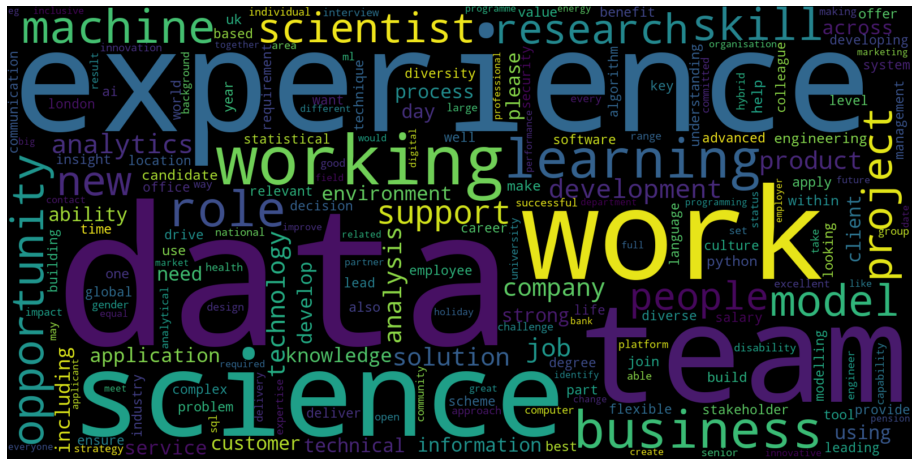

In [66]:
unigram_freq = Counter(all_words)
unigram_freq = dict(sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True))
show_wordcloud(unigram_freq)

In [67]:
# creates higher order n-grams of the text element

def create_ngrams(full_text, n):
    n_grams =  []
    for i in range(len(full_text)-(n-1)):
        elements = []
        for j in range(n):
            elements.append(full_text[i+j])

        n_grams.append(elements)

    return [' '.join(item) for item in n_grams]

In [68]:
# calculates frequencies of n-gram elements

def n_gram_freq(n_grams):
    ngram_freq = Counter(n_grams)
    ngram_freq = dict(sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True))

    return ngram_freq

### Bigram

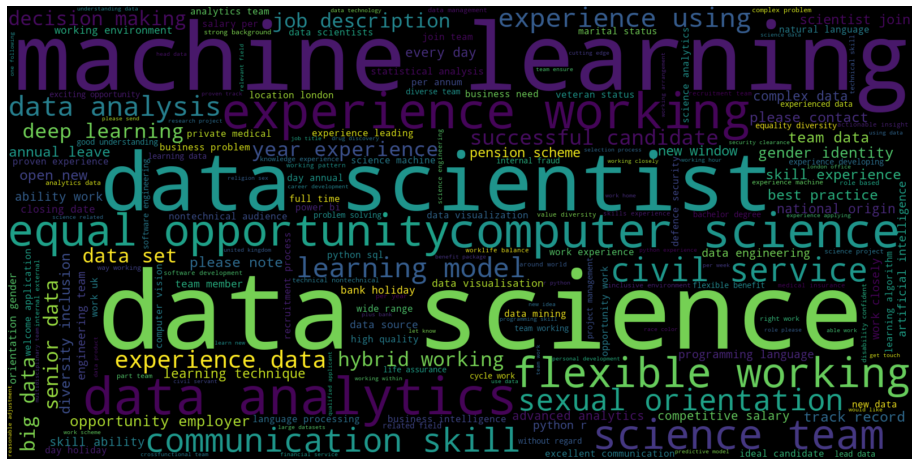

In [69]:
bigram_freq = n_gram_freq(create_ngrams(all_words, 2))
show_wordcloud(bigram_freq)

The dataset still contains some noise. There are some words and phrases that are not relevant to our purpose. The list of stopwords in the nltk library contains only the common stopwords. We need some problem specific stopwords. As the analysis is of "data scientist" jobs, finding the term with high frequency is quite obvious. Even "machine learning" and "data analytics" do not add any new insight about the patterns in job descriptions. After careful observation, I prepared a list of stopwords that can be eliminated from the analysis. How many words and phrases can you spot in the word cloud that you would treat as noise? 

In [70]:
prob_specific_stopwords = pd.read_csv('stopwords.csv')
prob_specific_stopwords = list(prob_specific_stopwords['Words'])

In [71]:
# removing additional stopwords
filtered_all_words = [x.strip() for x in all_words if x not in prob_specific_stopwords]
filtered_all_desc = ' '.join(filtered_all_words)

# removing some phrases
filtered_all_desc = filtered_all_desc.replace("data science", "")
filtered_all_desc = filtered_all_desc.replace("data scientist", "")
filtered_all_desc = filtered_all_desc.replace("data analysis", "")
filtered_all_desc = filtered_all_desc.replace("data analytics", "")
filtered_all_desc = filtered_all_desc.replace("machine learning", "")


filtered_all_words = nltk.word_tokenize(filtered_all_desc)

Let's take a look at the new wordclouds after removing some more noise from the dataset

### 1-gram

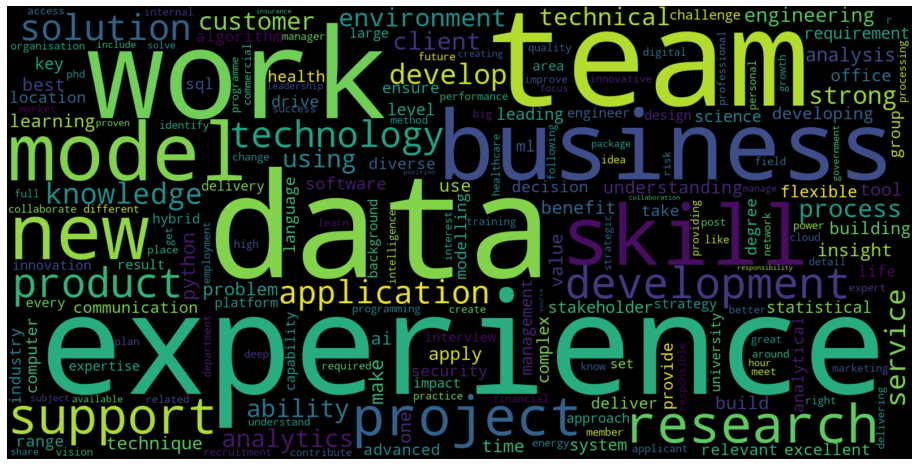

In [72]:
unigram_freq = Counter(filtered_all_words)
unigram_freq = dict(sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True))

show_wordcloud(unigram_freq)


### 2-gram

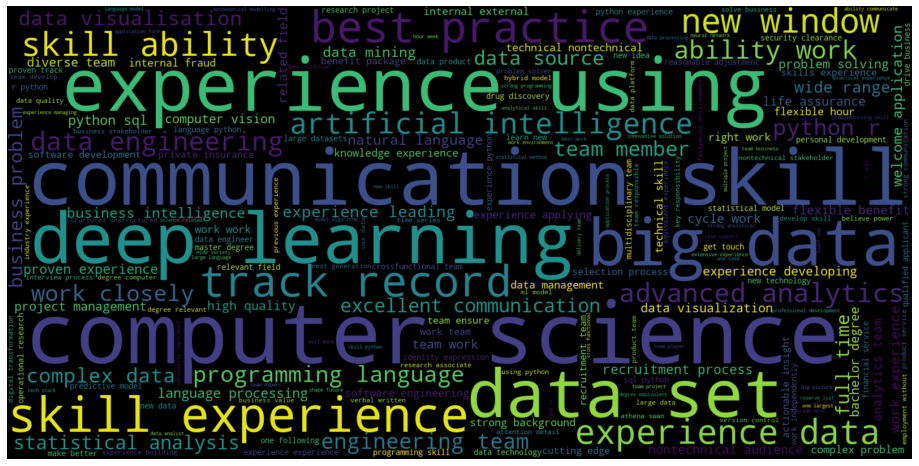

In [73]:

bigram_freq = n_gram_freq(create_ngrams(filtered_all_words, 2))
show_wordcloud(bigram_freq)



### 3-gram

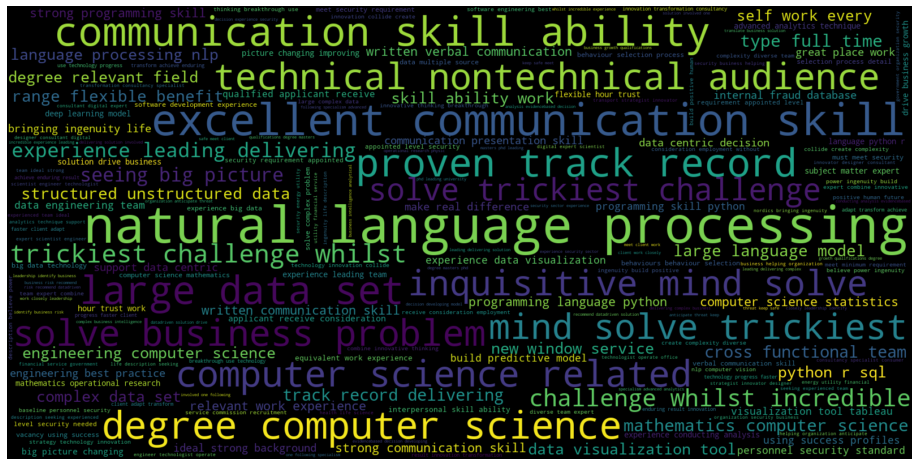

In [74]:

trigram_freq = n_gram_freq(create_ngrams(filtered_all_words, 3))
show_wordcloud(trigram_freq)



### 4-gram

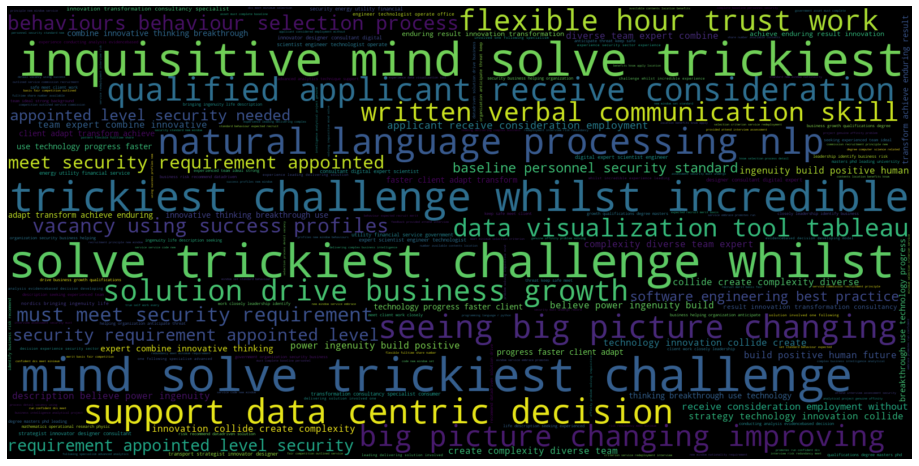

In [75]:

tetragram_freq = n_gram_freq(create_ngrams(filtered_all_words, 4))
show_wordcloud(tetragram_freq)



In [ ]:
pentagram_freq = n_gram_freq(create_ngrams(filtered_all_words, 5))

The results of the 2-gram and 3-gram frequency analysis seem to be what we are looking for. Most of them are phrases both directly and indirectly related to data science jobs. Even though 1-gram gives us the most frequently occurring words in a job description but they do not have any associated context, without which a single word has less meaning. One might want to generate even higher order n-grams for phrases with more information, but it may be counter productive as can be seen in the 4-gram word cloud. Since the data is processed, a longer phrase may not make complete sense in the absence of cetain words that add continuity to language. You may have also noticed the gradually decreasing font size with each increasing n-gram analysis. This is because range of frequencies among the n-gram elements decrease. It is quite intuitive. A single word can occur a number of times but there are far lesser instances of a specific sequence of words occurring. To check at which point the changes in frequency become less significant, we can perform a t-test as done below.

In [22]:
# performs t-test between the frequencies of 2 different n-gram elements
# H0 = There is no significant difference between the mean frequencies of both sets of n-grams
# H1 = The mean frequency of the lower order n-gram is significantly higher than that of the higher order

def ttest_pval(series1, series2):
    random.seed(2)
    list1 = []
    list2 = []
    for i in range(30):
        s1 = random.sample(series1, 10)   # randomly samples 10 frequencies and records the mean
        s2 = random.sample(series2, 10)
        list1.append(np.mean(s1))
        list2.append(np.mean(s2))

        
    # using ttest_rel as the samples are related
    t_statistic, p_value = stats.ttest_rel(list1, list2, alternative='greater')

    return round(p_value,5)

In [23]:
list1 = list(unigram_freq.values())
list2 = list(bigram_freq.values())
list3 = list(trigram_freq.values())
list4 = list(tetragram_freq.values())
list5 = list(pentagram_freq.values())

data = [list1, list2, list3, list4, list5]

In [24]:
p_value_df = pd.DataFrame(columns=[1, 2, 3, 4, 5])
for i in range(5):
    p_value_df.loc[i] = [float('nan')]*5

p_value_df.index = list(range(1, 6))

In [25]:
for i in range(len(data)):
    for j in range(i+1, len(data)):
        p_value_df[j+1].loc[i+1] = ttest_pval(data[i], data[j])


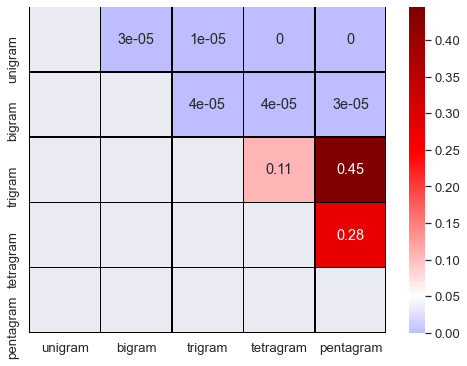

In [38]:
plt.figure(figsize=(8,6))
mask = np.tril(np.ones_like(p_value_df))
labels = ['unigram', 'bigram', 'trigram', 'tetragram', 'pentagram']
sns.set(font_scale=1.2)
sns.heatmap(p_value_df, cmap="seismic", annot=True, mask=mask, center=0.05, xticklabels=labels, 
            yticklabels=labels, linecolor='black', linewidths=0.5)
plt.show()

In the above heatmap, the blue intersections are the comparisons where the null hypothesis was rejected, meaning the frequency of occurrence of the n-gram elements of lower order were significantly higher. But it stopped being significant when 3-grams were tested against 4-gram elements. While we want the most commonly occurring words and phrases (tending to a lower order n-gram) we also want some linguistic context to our observations (tending to a higher order n-gram). Therefore, a balance is required in selecting the choice of n-gram appropriate for the problem objective. In this scenario, 2 and 3-gram analysis are most beneficial as a lower order n-gram lacks adequate information while a higher order n-gram is ultimately composed of lower orders and doesn't contribute to the most commonly occurring phrases whilst also adding noise to the observations.